In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import LambdaCallback
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [3]:
data = np.load('C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Code/Test/Blueberry/Datasets/Blueberry_SM.npy', allow_pickle= True)
data.shape

(12570, 463)

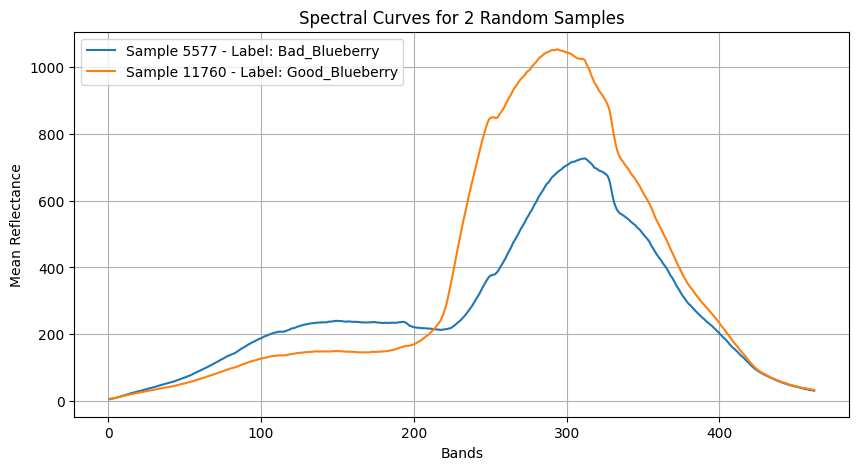

In [7]:
def plot_random_spectral_curves(data, num_samples=2):
    
    # Randomly choose `num_samples` rows
    random_indices = np.random.choice(data.shape[0], num_samples, replace=False)

    # Set up the plot
    plt.figure(figsize=(10, 5))

    for i, idx in enumerate(random_indices):
        # Extract the spectral values (excluding the label)
        spectral_values = data[idx, :-1]

        # Extract the label (last column)
        label = data[idx, -1]

        # Create the x-axis for wavelength index (1 to 300)
        wavelengths = np.arange(1, spectral_values.shape[0] + 1)

        # Plot the spectral curve
        plt.plot(wavelengths, spectral_values, label=f"Sample {idx} - Label: {label}")


    plt.title(f"Spectral Curves for {num_samples} Random Samples")
    plt.xlabel("Bands")
    plt.ylabel("Mean Reflectance")
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_random_spectral_curves(data) 

In [8]:
X= data[:, :-1]
y= data[:, -1]  

X.shape, y.shape

((12570, 462), (12570,))

In [9]:
scaler = StandardScaler()
scaler.fit(X)

Xn = scaler.transform(X)

In [10]:
# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.25, random_state=42, stratify=y)

X_train.shape,y_train.shape,X_test.shape

((9427, 462), (9427,), (3143, 462))

In [11]:
param_grid = {
    
    'n_neighbors': [3, 5],  # Use fewer values to test
    'weights': ['uniform'],  # Try with just one weight for now
    'metric': ['euclidean']  # Test one distance metric at a time
}

# KNN classifier
knn_classifier = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Training
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean'], 'n_neighbors': [3, 5],
                         'weights': ['uniform']},
             scoring='accuracy')

In [12]:
# test Accuracy
y_test_pred = grid_search_knn.predict(X_test)

accuracy = np.mean(y_test_pred == y_test) * 100
print("Test Accuracy:", accuracy)

Test Accuracy: 79.51002227171492


In [13]:
# Initialize the encoder
le= LabelEncoder()
y_encoded= le.fit_transform(y)

X_train2, X_test2, y_train2, y_test2 = train_test_split(Xn, y_encoded, test_size=0.25, random_state=42)

X_train2.shape,y_train2.shape

((9427, 462), (9427,))

In [14]:
unique_classes = np.unique(y)
print(unique_classes)

unique_classes_encoded = np.unique(y_encoded)
print(unique_classes_encoded)

['Bad_Blueberry' 'Good_Blueberry']
[0 1]


In [15]:
# Train XGBoost
xgb_classifier = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [7],
    'learning_rate': [0.01],
    'n_estimators': [100]
}


# GridSearchCV for XGBoost Classifier
xgb_grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
xgb_grid_search.fit(X_train2, y_train2)

# Get best parameters for XGBoost Classifier
best_params = xgb_grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}


In [16]:
# Get the best estimator
best_xgb_model = xgb_grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test2)

# Calculate the accuracy
accuracy = accuracy_score(y_test2, y_pred)
print("Accuracy:", accuracy*100)

Accuracy: 75.2465797009227


In [17]:
from sklearn.svm import SVC

param_dist = {
    
    'C': [0.1, 1, 10, 100],         
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4, 5], 
    'coef0': [0.0, 0.1, 0.5, 1.0] 
    
}
# SVM classifier
svc = SVC()

# Instantiate the grid search
random_search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Training
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'coef0': [0.0, 0.1, 0.5, 1.0],
                                        'degree': [2, 3, 4, 5],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=42, verbose=2)

In [18]:
# Best parameters found by RandomizedSearchCV
print("Best parameters:", random_search.best_params_)

# Use the best model to predict on the test data
y_pred = random_search.best_estimator_.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy*100)

Best parameters: {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'coef0': 1.0, 'C': 100}
Accuracy: 96.08654152083996


In [19]:
from sklearn.naive_bayes import GaussianNB

# Initialize Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [20]:
# test Accuracy
y_test_pred = nb_classifier.predict(X_test)

accuracy = np.mean(y_test_pred == y_test) * 100
print("Test Accuracy:", accuracy)

Test Accuracy: 63.44257079223672


In [21]:
config = tf.compat.v1.ConfigProto(gpu_options =
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)

config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  1


In [22]:
#Neural Network

tf.random.set_seed(1234) # for consistent results

model = Sequential(
    [
        tf.keras.Input(shape=(462,)),
        Dense(units=30, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='layer1'),
        #Dense(units=15, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='layer2'),
        #Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.0001), name='layer3'),
        
        Dense(units=2, activation='linear')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 30)                13890     
                                                                 
 dense (Dense)               (None, 2)                 62        
                                                                 
Total params: 13,952
Trainable params: 13,952
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Training

model.compile(
    
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2),
)

model.fit(
    
    X_train2,y_train2,
    batch_size = 500,
    epochs = 1000,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor = 'loss',
            patience = 500,
            restore_best_weights = True
        )
    ]
)

Epoch 1/1000
19/19 [==============================] - 2s 3ms/step - loss: 1.8743
Epoch 2/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.6708
Epoch 3/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5893
Epoch 4/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5604
Epoch 5/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5529
Epoch 6/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5393
Epoch 7/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5375
Epoch 8/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5236
Epoch 9/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5236
Epoch 10/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5173
Epoch 11/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5176
Epoch 12/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5041
Epoch 13/1000
19/19 [====

In [24]:
predictions = model.predict(X_test2)
predicted_labels = np.argmax(predictions, axis=1)

#Accuracy
# Calculate total accuracy
total_accuracy = accuracy_score(y_test2, predicted_labels)

print(f"Total Test Accuracy: {total_accuracy*100}")

99/99 [==============================] - 0s 797us/step
Total Test Accuracy: 89.62774419344576
